## Download data  

In [ ]:
!gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 42.4MB/s]


## Giải nén data

In [ ]:
!unzip -q "/content/FER-2013.zip"

## Load và xử lý data dạng ảnh 

### Cách xử lý data dùng tf.data

#### Sử dụng Tensorflow để  build, compile và train và evaluate model. Kết quả train và evaluation được thể hiện bằng hình ảnh bằng cách sử dụng matplotlib 

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [ ]:
batch_size = 256
img_height = 48
img_width = 48
image_count = 28709 
train_dir = pathlib.Path("/content/train") 
test_dir = pathlib.Path("/content/test")   

In [ ]:
list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(7):
  print(f.numpy())

b'/content/train/neutral/Training_40464326.jpg'
b'/content/train/fear/Training_89575609.jpg'
b'/content/train/neutral/Training_94342256.jpg'
b'/content/train/sad/Training_39660363.jpg'
b'/content/train/sad/Training_70583207.jpg'
b'/content/train/happy/Training_34322110.jpg'
b'/content/train/happy/Training_96376941.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

normalized_train_ds = list_ds.skip(val_size)
normalized_val_ds = list_ds.take(val_size)

In [ ]:
# number of data
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

22968
5741


In [ ]:
a = '/content/train/neutral/Training_79965780.jpg'
tf.strings.split(a, os.path.sep)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'', b'content', b'train', b'neutral', b'Training_79965780.jpg'],
      dtype=object)>

In [ ]:
np.array(["neutral"]) == np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

array([False, False, False, False,  True, False, False])

In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img, norm):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=1)
  # Resize the image to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # normalize
  if norm:
    img = img/127.5 - 1
  return img

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, norm=False)
  return img, label

def process_path_with_norm(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, norm=True)
  return img, label

In [ ]:
# for f in list_ds.take(7):
#   print(f.numpy())
#   print(process_path(f.numpy())[1])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

normalized_train_ds = normalized_train_ds.map(process_path_with_norm, num_parallel_calls=AUTOTUNE)
normalized_val_ds = normalized_val_ds.map(process_path_with_norm, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (48, 48, 1)
Label:  3


In [ ]:
def configure_for_performance(ds, train):
  ds = ds.cache()
  if train:
    ds = ds.shuffle(buffer_size=512)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds2 = configure_for_performance(train_ds, train=True)
val_ds2 = configure_for_performance(val_ds, train=False)

normalized_train_ds2 = configure_for_performance(normalized_train_ds, train=True)
normalized_val_ds2 = configure_for_performance(normalized_val_ds, train=False)

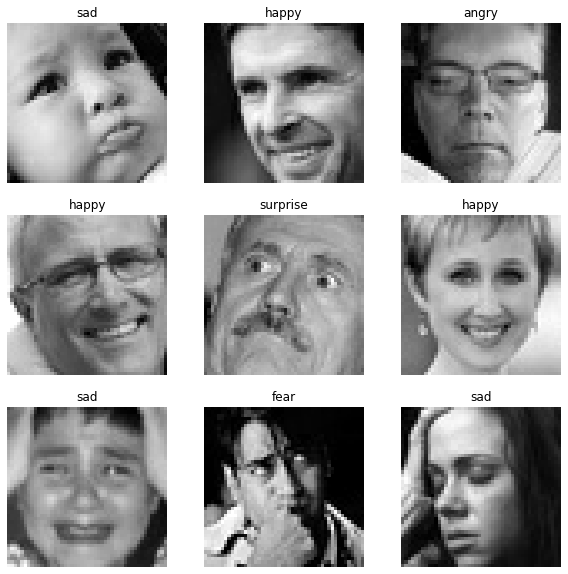

In [ ]:
image_batch, label_batch = next(iter(train_ds2))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

##### MLP - tanh

In [ ]:
num_class = 7

#
MLP_tanh_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=1024, activation="tanh"),
    tf.keras.layers.Dense(units=512, activation="tanh"),
    tf.keras.layers.Dense(units=256, activation="tanh"),
    tf.keras.layers.Dense(units=num_class)
])
MLP_tanh_model.summary()
#
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)

MLP_tanh_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

#
MLP_tanh_history = MLP_tanh_model.fit(normalized_train_ds2, validation_data=normalized_val_ds2, epochs=100)

# Epoch 100/100
# 90/90 [==============================] - 1s 6ms/step - loss: 1.0167 - accuracy: 0.6567 - val_loss: 1.6812 - val_accuracy: 0.3839

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3,018,247
Trainable params: 3,018,247
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
90/90 [===========================

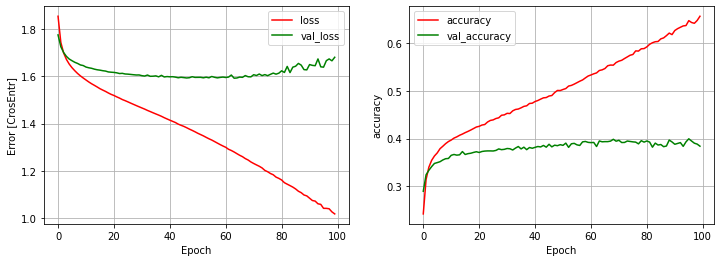

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='red')
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)


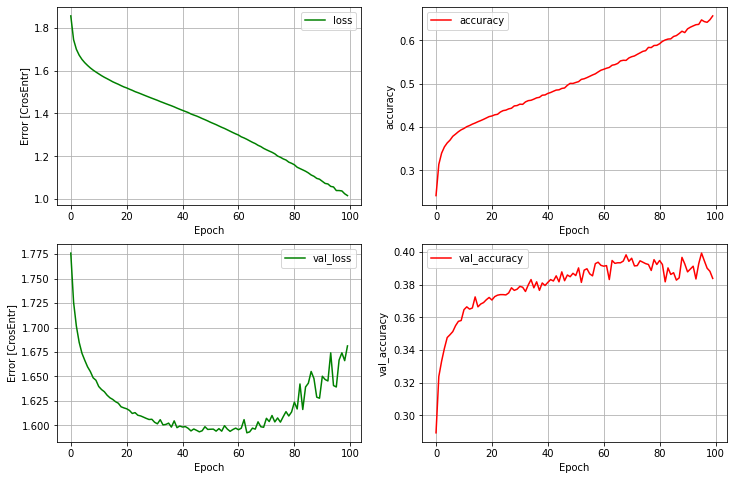

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [ ]:
hist = pd.DataFrame(MLP_tanh_history.history)
hist['epoch'] = MLP_tanh_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.040349,0.647510,1.639261,0.399408,95
96,1.040295,0.643591,1.666795,0.394705,96
97,1.038533,0.641937,1.674168,0.390176,97
98,1.025328,0.647858,1.666170,0.388260,98
99,1.016705,0.656740,1.681246,0.383905,99


In [ ]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.6567398309707642
Max val acc:  0.3994077742099762
Min train loss:  1.0167046785354614
Min val loss:  1.5923866033554077
